In [1]:
import  numpy as np
import matplotlib as plt

In [2]:
from qiskit import BasicAer, Aer, IBMQ
from qiskit import QuantumRegister ,ClassicalRegister,QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.aqua.operators import I, X, Y, Z

from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.components.optimizers import COBYLA

from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

from qiskit import IBMQ

In [3]:
#jut a dirty trick
from scipy.optimize import minimize

from lib.math_sh import decompose
from lib.expected import expected
from lib.inefficient_VQE import ansatz_cell,var_circ,value,cost,Exact_solver

In [ ]:
IBMQ.save_account('')
IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers

In [ ]:
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

In [4]:
#local simulator
backend=Aer.get_backend('qasm_simulator')

In [5]:
basis='sto3g'
inter_dist=1.316
# Molecule
atoms = 'Be .0 .0 .0; H .0 .0 '+str(inter_dist)+';H .0 .0 '+str(-1*inter_dist)
driver = PySCFDriver(atoms, unit=UnitsType.ANGSTROM, charge=0, spin=0, basis=basis,max_memory=None)

#integral h_{lm} , h_{lmpq}
molecule = driver.run()
h1 = molecule.one_body_integrals
h2 = molecule.two_body_integrals
nuclear_repulsion_energy = molecule.nuclear_repulsion_energy

num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2

print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
print("# nr. of electrons: {}".format(num_particles))
print("# nr. of spin orbitals: {}".format(num_spin_orbitals))


HF energy: -18.978759625101418
# nr. of electrons: 6
# nr. of spin orbitals: 14


In [6]:
ferOp = FermionicOperator(h1=h1, h2=h2)
qubitOp = ferOp.mapping(map_type='jordan_wigner')

print("After freezing and remouve!")
print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
print("# nr. of electrons: {}".format(num_particles))
print("# nr. of spin orbitals: {}".format(num_spin_orbitals))

After freezing and remouve!
HF energy: -18.978759625101418
# nr. of electrons: 6
# nr. of spin orbitals: 14


In [7]:
print(qubitOp)
print(qubitOp.print_details())

weight=[]
pauli=[]
for w,i in qubitOp._paulis:
    weight.append(w)
    pauli.append(i.to_label())

Representation: paulis, qubits: 14, size: 666
IIIIIIIIIIIIII	(-12.1019643095543+0j)
IIIIIIIIIIIIIZ	(2.216493503065026+0j)
IIIIIIIIIIIIYY	(0.03222448117575346+0j)
IIIIIIIIIIIIXX	(0.03222448117575346+0j)
IIIIIIIIYZZZZY	(0.025248216094970556+0j)
IIIIIIIIXZZZZX	(0.025248216094970556+0j)
IIIIIIIIIIIIZI	(0.007861628756603303+0j)
IIIIIIIIYZZZYI	(-0.028060529427079588+0j)
IIIIIIIIXZZZXI	(-0.028060529427079588+0j)
IIIIIIIIIIIZII	(-0.022337188360987872+0j)
IIIIIIIYZZZYII	(-0.01038542904451061+0j)
IIIIIIIXZZZXII	(-0.01038542904451061+0j)
IIIIIIIIIIZIII	(-0.1474323329000415+0j)
IIIIIIIIIZIIII	(-0.14743233290004135+0j)
IIIIIIIIZIIIII	(-0.2676143379167141+0j)
IIIIIIIZIIIIII	(-0.48282474993748264+0j)
IIIIIIZIIIIIII	(2.2164935030650246+0j)
IIIIIYYIIIIIII	(0.03222448117575349+0j)
IIIIIXXIIIIIII	(0.03222448117575349+0j)
IYZZZZYIIIIIII	(0.02524821609497065+0j)
IXZZZZXIIIIIII	(0.02524821609497065+0j)
IIIIIZIIIIIIII	(0.007861628756603106+0j)
IYZZZYIIIIIIII	(-0.028060529427079546+0j)
IXZZZXIIIIIIII	(-0.0280

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


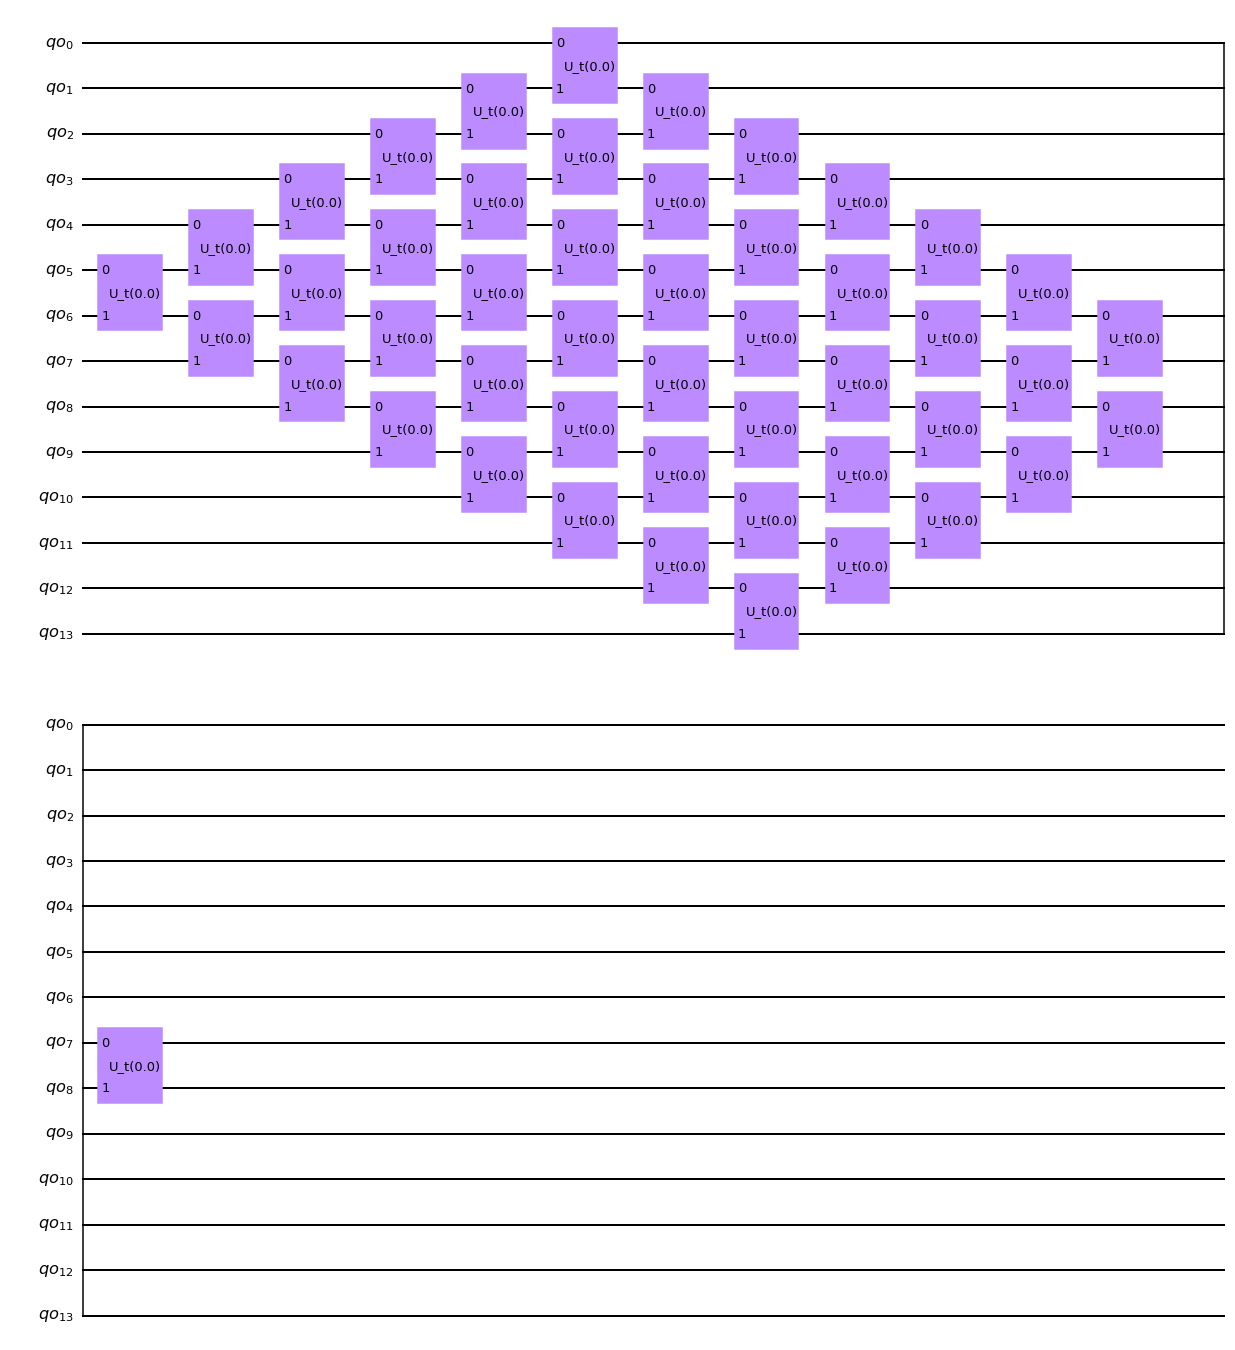

In [8]:
nr_o=num_spin_orbitals
nr_e=num_particles
nr_par=(nr_o-nr_e)*nr_e
theta=np.zeros(nr_par)
print(theta)
qo=QuantumRegister(nr_o,'qo')
ansatz = QuantumCircuit(qo)
ansatz_cell(ansatz,qo,nr_o, nr_e,theta)
ansatz.draw('mpl')

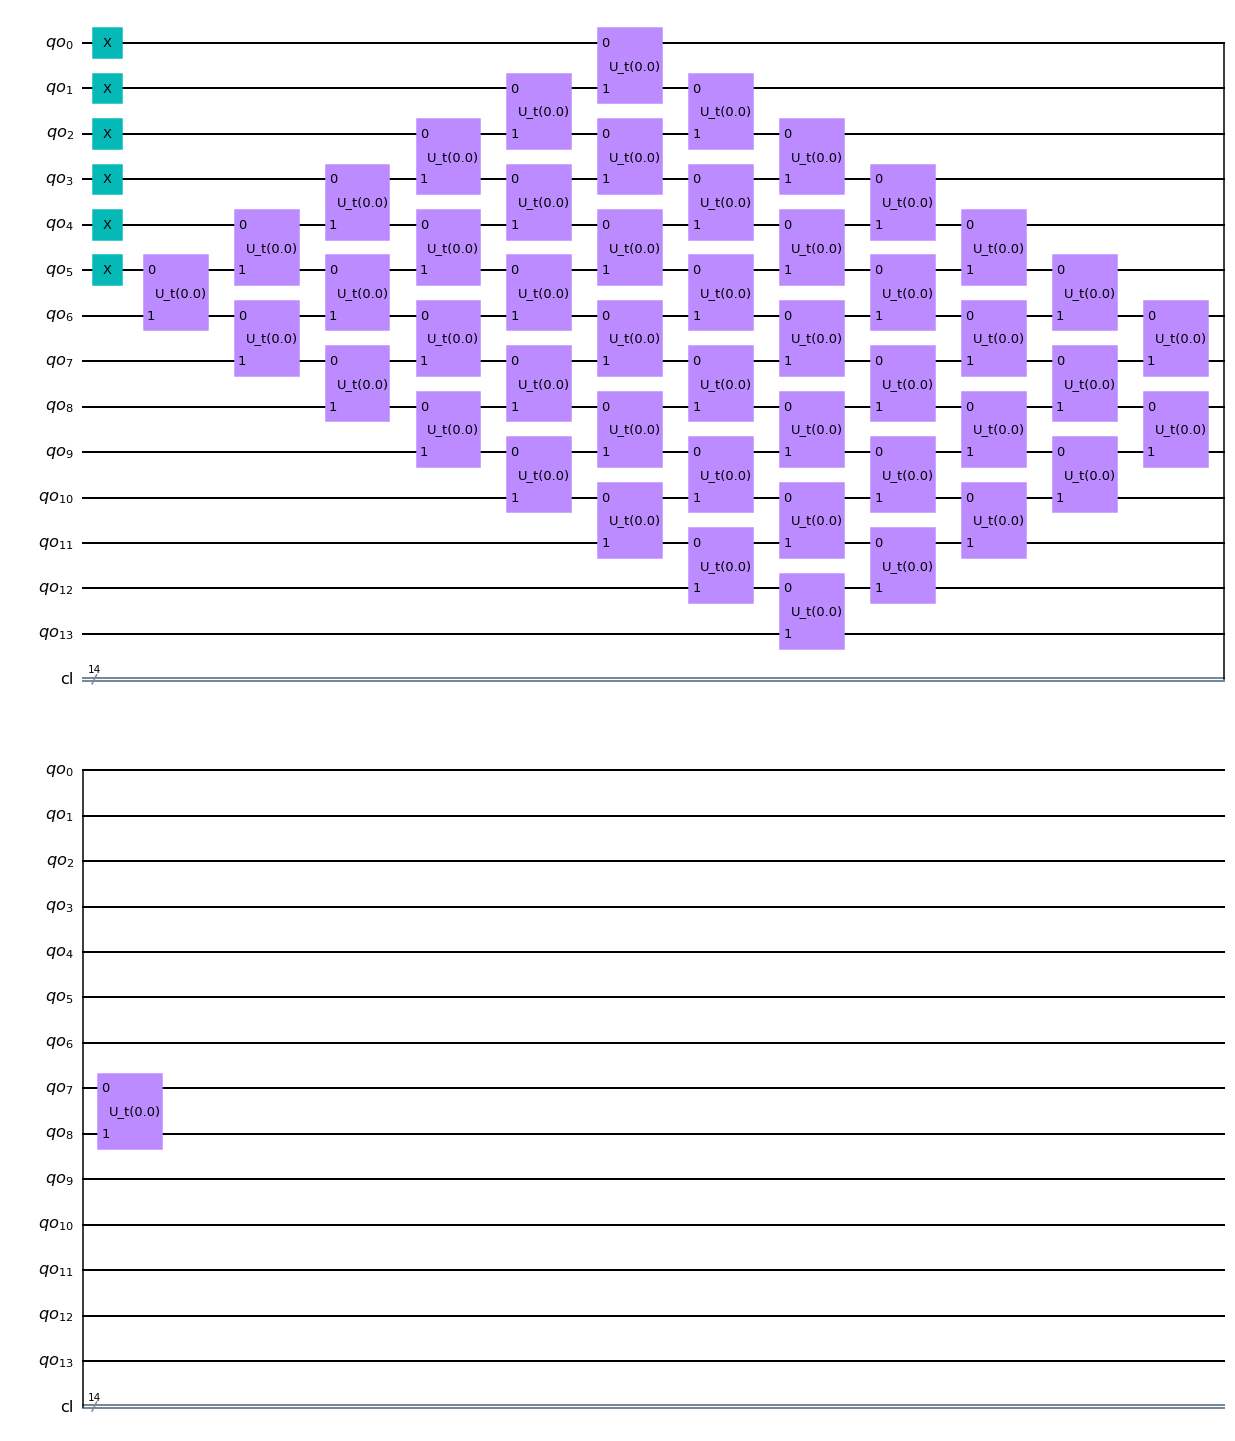

In [9]:
circ=var_circ(nr_o,nr_e,theta)
#print(value(weight,pauli,circ,backend))
circ.draw('mpl')

In [10]:
def VQE(weight,pauli,nr_o,nr_e,backend):
    
    theta=np.zeros(nr_par)
    optim=minimize(cost, 
                   theta,args=(weight,pauli,nr_o,nr_e,backend),
                   method='COBYLA', 
                   options={'rhobeg': 1.0, 'maxiter': 2000, 'disp': True, 'catol': 0.0002})
    
    circ=var_circ(nr_o,nr_e,optim.x)
    eigval=value(weight,pauli,circ,backend)
    
    return eigval


from qiskit.aqua.algorithms import NumPyEigensolver


In [ ]:
VQEresult=np.real(VQE(weight,pauli,nr_o,nr_e,backend))

In [ ]:
print("Result: ",VQEresult)
print("Reference:",Exact_solver(qubitOp))